In [109]:
# import libraries
import shap
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import json
from scipy.stats import  zscore
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import joblib



In [517]:

df = pd.read_csv("XGBoost_data.csv")
df['price'] = np.log(df['price'])

z_scores = zscore(df['price'])


z_score_threshold = 3

# Create a mask to filter data points within the threshold
mask = (z_scores >= -z_score_threshold) & (z_scores <= z_score_threshold)

# Apply the mask to filter the DataFrame
df = df[mask]
df = df.drop(['date','point', 'price_per_sqm','discount', 'epoch'], axis=1)
df['price'] = np.exp(df['price'])


In [519]:
df['badtoi'] = df['AntalBad'] + df['AntalToilet']
df.drop(['AntalBad','AntalToilet'],axis=1,inplace=True)

data_4_later = df.copy() # Data til senere brug ved SHAP!


scaler = StandardScaler()
minmax = MinMaxScaler()
df['weighted_price'] = scaler.fit_transform(df[['weighted_price']])
df['dist_coast'] = minmax.fit_transform(df[['dist_coast']])
df['dist_highway'] = minmax.fit_transform(df[['dist_highway']])
df['dist_railroads'] = minmax.fit_transform(df[['dist_railroads']])
df['dist_airports'] = minmax.fit_transform(df[['dist_airports']])
df['dist_school'] = minmax.fit_transform(df[['dist_school']])
df['dist_kindergarden'] = minmax.fit_transform(df[['dist_kindergarden']])
df['dist_waterlines'] = minmax.fit_transform(df[['dist_waterlines']])
df['dist_forests'] = minmax.fit_transform(df[['dist_forests']])



In [ ]:

for anvendelse in df.anvendelse.unique():
    dff = df[df['anvendelse'] == anvendelse]
    for column in dff.columns:
        if column != 'price':
            data = dff.drop(column, axis=1)
            data_dum = pd.get_dummies(data, prefix_sep='_' , drop_first=False)
            X = data_dum.drop('price', axis=1)
            y = data_dum['price']
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            xgb_reg = XGBRegressor(objective = 'reg:squarederror', random_state=42, n_jobs=-1, verbosity=1, eval_metric='rmse')
        
            model = xgb_reg.fit(X_train, y_train)

            predictions = xgb_reg.predict(X_test)

            MAE = np.mean(np.abs(predictions - y_test))

            absolute_percentage_error = np.abs(predictions - y_test) / y_test * 100
            pm20 = np.sum(np.abs(absolute_percentage_error) <= 20) / len(y_test) * 100
            print(f""" 
            Anvendelse == {anvendelse}
            Fjernet {column}.
            Fik MAE: {MAE}
            pm20: {pm20}
            """)
        else:
            print('Pris')

In [520]:
### Definer modeltype!
Model_variation = 'Rækkehus'
df = df[df['anvendelse'] == Model_variation]


In [521]:
df = df.drop('Sogn', axis=1)
data_dum = pd.get_dummies(df, prefix_sep='_' , drop_first=True)
X = data_dum.drop('price', axis=1)
y = data_dum['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:

param_grid = {
    'n_estimators': [500, 800, 1000],  
    'learning_rate': [0.005, 0.01, 0.05], 
    'max_depth': [20, 25, 30],  
    'subsample': [0.8, 0.9, 1.0],
    'gamma': [0.1, 0.2, 0.3] 
}

xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1, verbosity=2, eval_metric='rmse')
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=3, n_jobs=6)
grid_search.fit(X_train, y_train)


best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

In [ ]:
## GRID SEARCH er lavet i ucloud grundet tiden det tager at kører og mængden af RAM det kræver. MacBook M2 kan ikke følge med :(
grid = pd.read_csv("/work/raekke_uden_scal_grid.csv")
best_params_str = grid.loc[grid['rank_test_score'] == 1]['params'].values[0]
best_params = json.loads(best_params_str.replace("'", "\""))


xgb_reg = XGBRegressor(**best_params)

best_params

In [522]:
best_params = {'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 1000, 'subsample': 0.8, 'gamma' : 0.1}
xgb_reg = XGBRegressor(**best_params, objective='reg:squarederror', random_state=42, eval_metric='rmse')

In [523]:
model = xgb_reg.fit(X_train, y_train)

In [418]:
#Referer til model i model_filename
model_filename = f"Trænede modeller/{Model_variation}_endelig.joblib"

# Hvis model er trænet på ny, kør da nedenstående for at gemme.
#joblib.dump(model, model_filename)

# Kør denne for at loade pre-trained model.
loaded_model = joblib.load(model_filename)

In [ ]:
## Cross validation scorer -- PM20
def percentage_within_threshold(y_true, y_pred):
    threshold = 0.2  
    absolute_percentage_error = np.abs((y_true - y_pred) / (y_true))
    within_threshold = absolute_percentage_error <= threshold
    return np.mean(within_threshold) * 100

scorer_pm20 = make_scorer(percentage_within_threshold, greater_is_better=True)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

scores_pm20 = cross_val_score(loaded_model, X, y, cv=kf, scoring=scorer_pm20)
for i, score in enumerate(scores_pm20, start=1):
    print(f'Fold {i}: {score:.2f}% within ±20%')

mean_score = np.mean(scores_pm20)
print(f'Percentage within ±20%: {mean_score:.2f}%')

In [59]:
## Cross validation scorer -- MAE
from sklearn.metrics import mean_absolute_error, make_scorer

scorer_MAE = make_scorer(mean_absolute_error)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

scores_MAE = cross_val_score(loaded_model, X, y, cv=kf, scoring=scorer_MAE)

for i, score in enumerate(scores_MAE, start=1):
    print(f'Fold {i}: {score:.2f}% ')

mean_score = np.mean(scores_MAE)
print(f'Mean absolute error: {mean_score:.2f}%')

Fold 1: -402795.20% 
Fold 2: -402880.13% 
Fold 3: -400858.32% 
Fold 4: -409546.70% 
Fold 5: -405821.21% 
Mean absolute error: -404380.31%


# Predictions

In [419]:
loaded_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=20, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [526]:
# Lav predictions til SHAP
predictions = loaded_model.predict(X_test)

In [527]:
prdict_kr = predictions
y_test_kr = y_test
np.mean(np.abs(prdict_kr - y_test_kr))

absolute_percentage_error = np.abs(prdict_kr - y_test_kr) / y_test_kr * 100
np.sum(np.abs(absolute_percentage_error) <= 20) / len(y_test_kr) * 100


72.28410832907511

<Figure size 640x480 with 0 Axes>

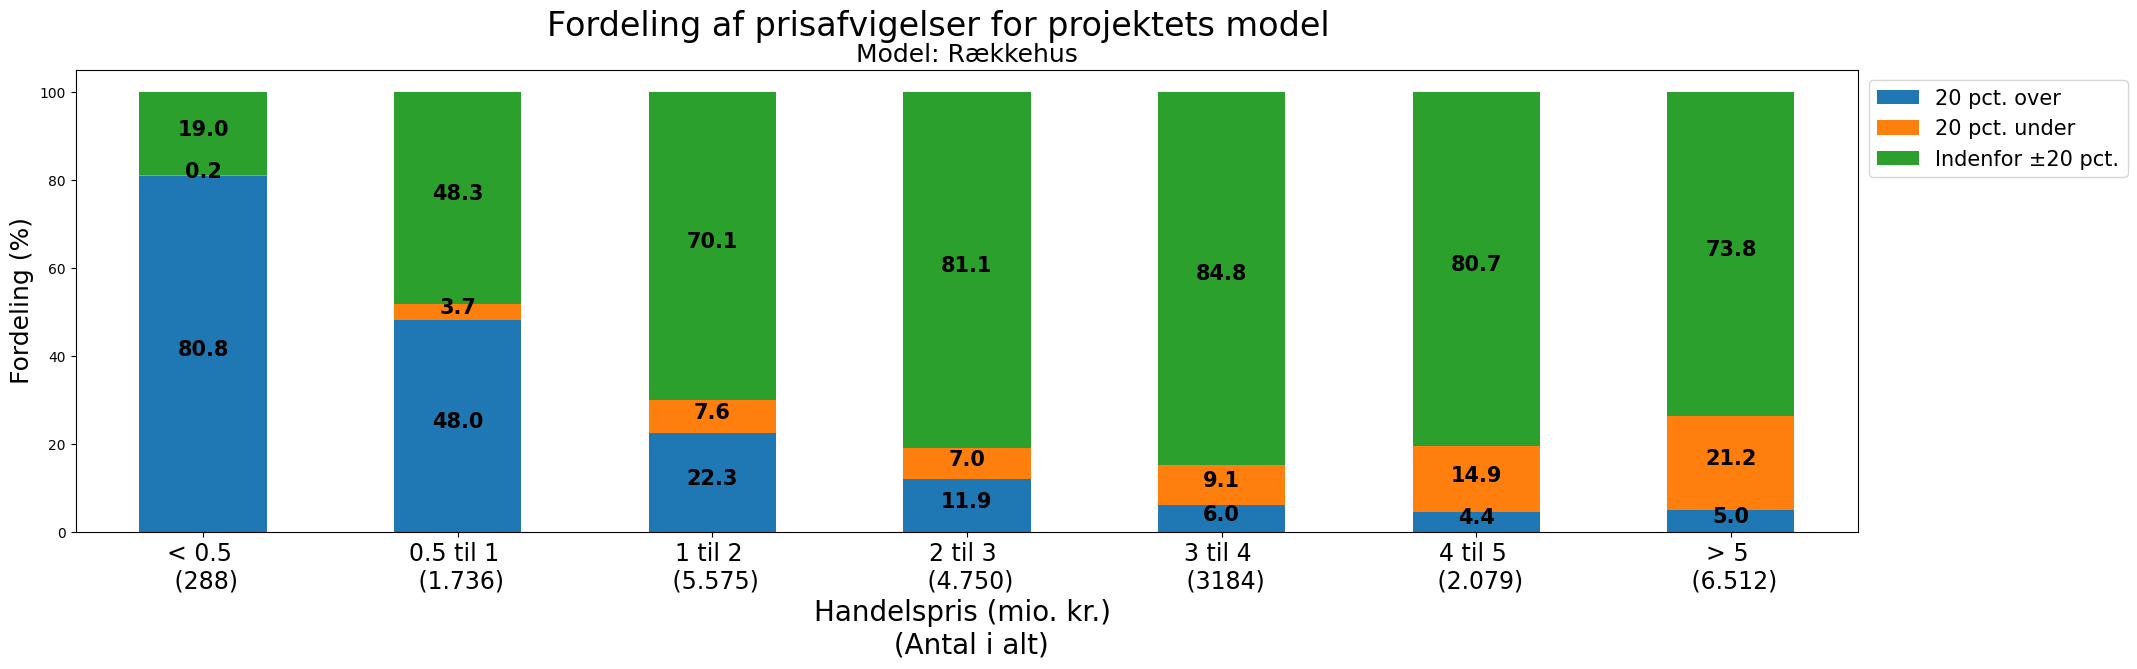

In [422]:
## Plots af predictions!
pris_afvigelse = pd.DataFrame({'predicted': prdict_kr, 'actual': y_test_kr})
pris_afvigelse['afvigelse'] = pris_afvigelse['predicted'] - pris_afvigelse['actual']
pris_afvigelse['pct_af'] = pris_afvigelse['afvigelse'] / pris_afvigelse['actual'] * 100

# Kategoriserings funktion
def categorize_price(row):
    if row['actual'] <= 500000:
        return 'under_500'
    elif 500000 < row['actual'] <= 1000000:
        return '500to1'
    elif 1000000 < row['actual'] <= 2000000:
        return '1to2'
    elif 2000000 < row['actual'] <= 3000000:
        return '2to3'
    elif 3000000 < row['actual'] <= 4000000:
        return '3to4'
    elif 4000000 < row['actual'] <= 5000000:
        return '4to5'
    elif row['actual'] > 5000000:
        return 'over_500'
    else:
        return None

# Projektets model -- predicted
pris_afvigelse['price_bin'] = pris_afvigelse.apply(categorize_price, axis=1)
pris_afvigelse['PM'] = np.where(pris_afvigelse['pct_af'] > 20, 'Over20',
                               np.where(pris_afvigelse['pct_af'] < -20, 'Under20', 'mellem'))

over_under_data_projekt = pd.DataFrame({'20 pct. over': pris_afvigelse.groupby(['price_bin'])['PM'].value_counts(normalize=True).loc[:,'Over20'].values*100,
                '20 pct. under': pris_afvigelse.groupby(['price_bin'])['PM'].value_counts(normalize=True).loc[:,'Under20'].values*100,
                'Indenfor ±20 pct.': pris_afvigelse.groupby(['price_bin'])['PM'].value_counts(normalize=True).loc[:,'mellem'].values*100},
                index = pris_afvigelse.groupby(['price_bin'])['PM'].value_counts(normalize=True).loc[:,'Over20'].index)
over_under_data_projekt = over_under_data_projekt.reindex(['under_500', '500to1', '1to2', '2to3', '3to4', '4to5', 'over_500'])

# Projekt resultater plots
plt.figure()
fig, ax = plt.subplots(figsize=(23, 6))
over_under_data_projekt.plot.bar(stacked=True, ax=ax, rot=0, title='Fordeling af prisafvigelser for projektets model')
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', label_type='center', color='black', fontsize=15, weight='bold', padding=3)
ax.set_xticks(range(len(['< 0.5','0.5 til 1' ,'1 til 2','2 til 3' ,'3 til 4', '4 til 5', '> 5'])))

ax.set_xticklabels(['< 0.5 \n (288)','0.5 til 1 \n (1.736)' ,'1 til 2 \n (5.575)','2 til 3 \n (4.750)' ,'3 til 4 \n (3184)',
                     '4 til 5 \n (2.079)', '> 5 \n (6.512)'], fontsize=17)

ax.set_xlabel('Handelspris (mio. kr.) \n (Antal i alt)', fontsize=20)
ax.set_ylabel('Fordeling (%)', fontsize=18)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
plt.title(f'Model: {Model_variation}', fontsize=18)
plt.suptitle('Fordeling af prisafvigelser for projektets model', fontsize=24)
plt.show()

In [218]:
pris_afvigelse['PM'].value_counts(normalize=False)

mellem     14318
Over20      3546
Under20     1706
Name: PM, dtype: int64

In [213]:
pris_afvigelse['price_bin'].value_counts()

1to2         5580
2to3         5330
3to4         3186
500to1       1985
4to5         1536
over_500     1485
under_500     468
Name: price_bin, dtype: int64

In [392]:
Testing_X = X_test.copy()

Testing_X['weighted_price'] = scaler.inverse_transform(Testing_X['weighted_price'].to_numpy().reshape(-1,1))

Testing_X['price'] = y_test_kr
Testing_X['predicted'] = prdict_kr
Testing_X['afvigelse_predict'] = (Testing_X['predicted'] - Testing_X['price']) 
Testing_X['afvigelse_predict_pct'] = Testing_X['afvigelse_predict'] / Testing_X['price'] * 100
Testing_X['afvigelse_weight'] = (Testing_X['weighted_price'] - Testing_X['price'])
Testing_X['within_20'] = np.where(np.abs(Testing_X['afvigelse_predict_pct']) <= 20, '±20', 
                                  np.where((Testing_X['afvigelse_predict_pct']) <= -20, '-20', '+20'))

<Figure size 640x480 with 0 Axes>

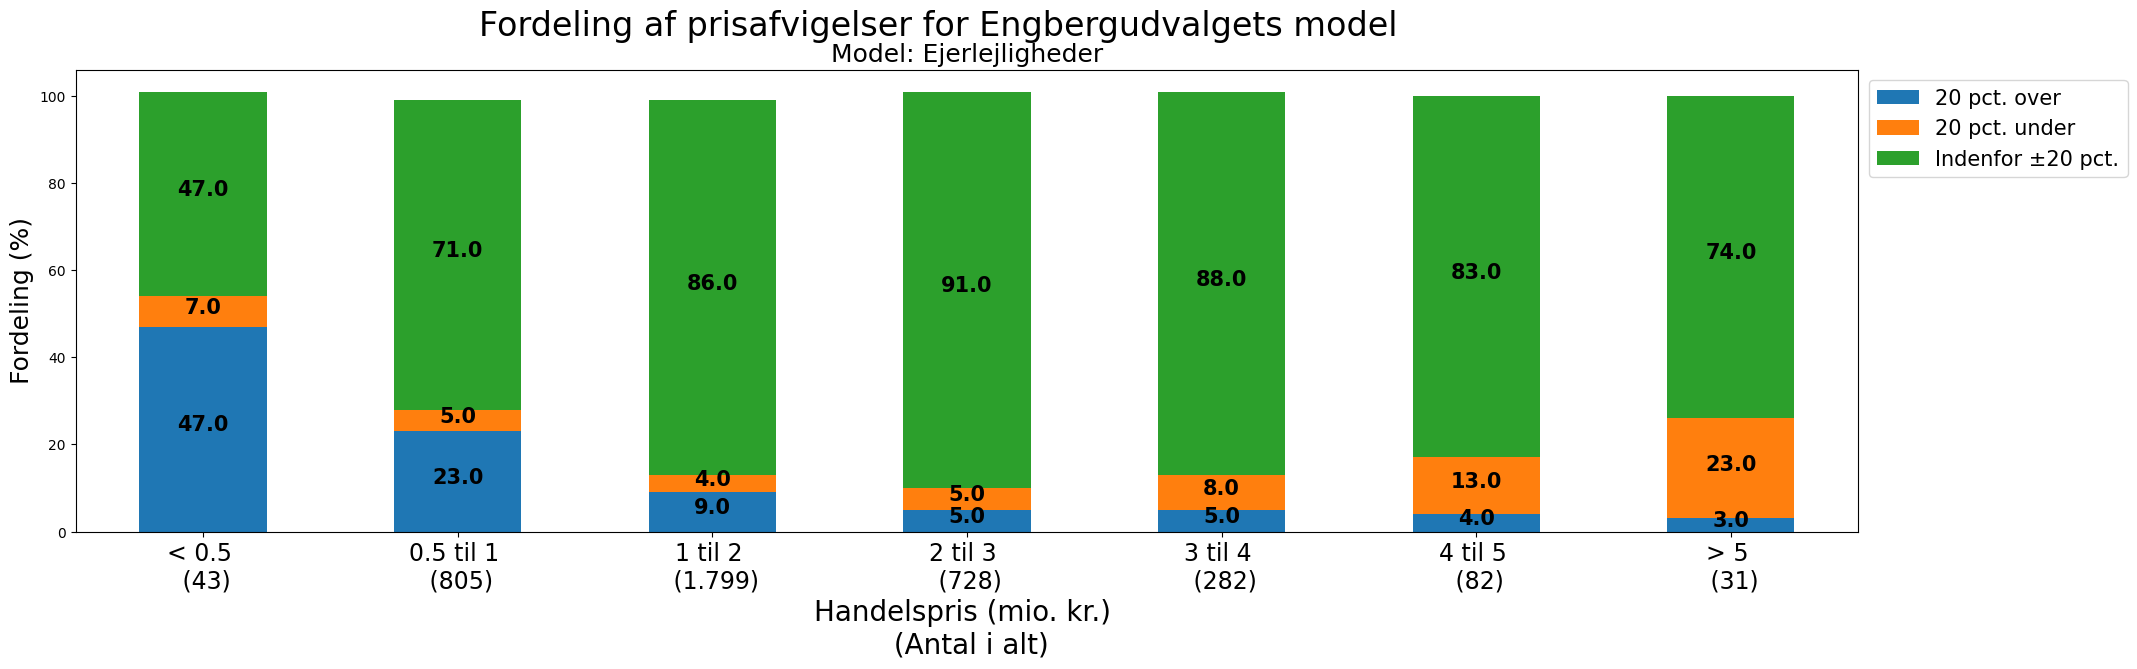

In [423]:
## Engbergudvalget plots -- Data ændres afhængigt af model
over_under_data_engberg = pd.DataFrame({'20 pct. over': [47,23,9,5,5,4,3],
                                        '20 pct. under': [7,5,4,5,8,13,23],
                'Indenfor ±20 pct.': [47,71,86,91,88,83,74]}, 
                index=['under_500', '500to1', '1to2', '2to3', '3to4', '4to5','over_500'])
plt.figure()
fig, ax = plt.subplots(figsize=(23, 6))
over_under_data_engberg.plot.bar(stacked=True, ax=ax, rot=0, title='Fordeling af prisafvigelser for projektets model')
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', label_type='center', color='black', fontsize=15, weight='bold', padding=3)
ax.set_xticks(range(len(['< 0.5','0.5 til 1' ,'1 til 2','2 til 3' ,'3 til 4', '4 til 5', '> 5'])))

ax.set_xticklabels(['< 0.5 \n (43)','0.5 til 1 \n (805)' ,'1 til 2 \n (1.799)','2 til 3 \n (728)' ,'3 til 4 \n (282)',
                     '4 til 5 \n (82)', '> 5 \n (31)'], fontsize=17)

ax.set_xlabel('Handelspris (mio. kr.) \n (Antal i alt)', fontsize=20)
ax.set_ylabel('Fordeling (%)', fontsize=18)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
plt.title('Model: Ejerlejligheder', fontsize=18)
plt.suptitle('Fordeling af prisafvigelser for Engbergudvalgets model', fontsize=24)
plt.show()

# SHAP

In [424]:
# Opret Explainer til at beregner SHAP -- Hvis model er trænet på ny og ikke benyttet pre-loaded, ændre da loaded_model!
explainer = shap.TreeExplainer(loaded_model, feature_perturbation='tree_path_dependent', gpu=False, approximate=True)

[21:04:51] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [425]:
# Approximate=True er valgt da det ellers tager for lang tid at kører koden
shap_values = explainer.shap_values(X_test, approximate=True)

In [426]:
# Kode til at lave en dataframe med shap values for hver feature i original df.
original_feature_names = df.drop('price',axis=1).columns
shap_values_df = pd.DataFrame(shap_values, columns=X_test.columns)
shap_values_original = pd.DataFrame(index=shap_values_df.index, columns=original_feature_names)
for feature in original_feature_names:
     related_columns = [col for col in shap_values_df.columns if col.startswith(f"{feature.split('_')[0]}")]
     shap_values_original[feature] = shap_values_df[related_columns].sum(axis=1)

In [427]:
# Har samlede distancer under én, derfor fjernes alle distancemål på nær én, da de alle er ens efter celle ovenfor er kørt
shap_values_original.drop([ 'dist_highway', 'dist_railroads', 'dist_airports', 'dist_uni', 'dist_school', 'dist_kindergarden', 'dist_waterlines', 'dist_forests'],axis=1,inplace=True)
shap_values_original.rename(columns={'dist_coast': 'Distances'}, inplace=True)

In [428]:
# Gør det samme for den originale df
dff = df.copy()
dff['dist_coast'] = dff[['dist_coast','dist_highway', 'dist_railroads', 'dist_airports', 'dist_uni', 'dist_school', 'dist_kindergarden', 'dist_waterlines', 'dist_forests']].sum(axis=1)
dff.drop(['dist_highway', 'dist_railroads', 'dist_airports', 'dist_uni', 'dist_school', 'dist_kindergarden', 'dist_waterlines', 'dist_forests'], axis=1,inplace=True)
dff.rename(columns={'dist_coast': 'Distances'}, inplace=True)

# Dropper target variabel
dff.drop('price', axis=1,inplace=True)


In [429]:
# Giver ikke mening at have med
dff.drop('anvendelse', axis=1,inplace=True)
shap_values_original.drop('anvendelse', axis=1,inplace=True)

In [430]:
#Fanger de observationer der er kommet med i X_test sættet
X_test_shap = dff.loc[X_test.index]

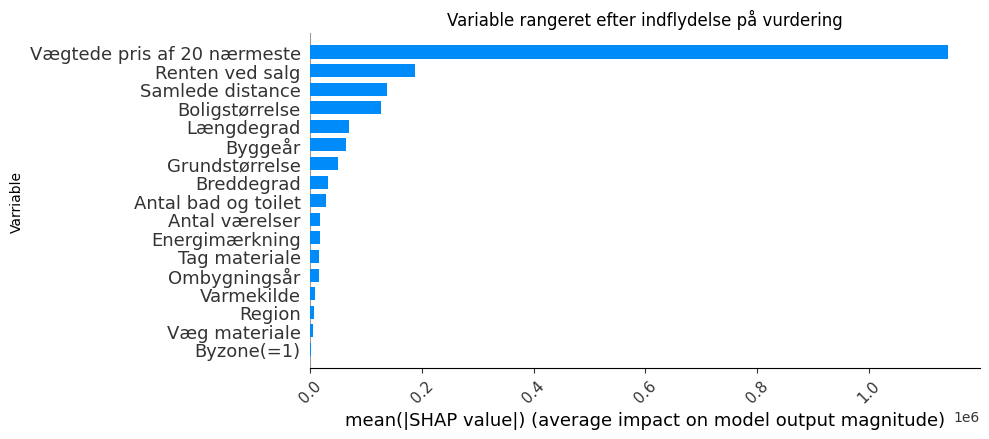

In [431]:
# Plot af feature importance!
feature_names_shap = ['Antal værelser', 'Byggeår', 'Boligstørrelse', 'Region', 'Byzone(=1)', 'Samlede distance',
       'Længdegrad', 'Breddegrad', 'Grundstørrelse', 'Varmekilde',
       'Renten ved salg', 'Tag materiale', 'Væg materiale', 'Ombygningsår',
       'Energimærkning', 'Vægtede pris af 20 nærmeste', 'Antal bad og toilet']


plt.title('Variable rangeret efter indflydelse på vurdering')  
plt.ylabel('Varriable')           
plt.xticks(rotation=45)

colors = plt.cm.viridis_r(shap_values_original.sum(0))  

shap.summary_plot(shap_values_original, X_test_shap, plot_type='bar', feature_names=feature_names_shap, plot_size=(10,4.5))

In [483]:
feature_names = ['Antal værelser', 'Bygningsår', 'Boligstrørelse', 'Byzone(=1)', 'Distance til kyst', 'Distance til motorvej',
       'Distance til togspor', 'Distance til lufthavn', 'Længdegrad', 'Breddegrad', 'Grundstrørelse',
       'Renten', 'Distance til Universitet', 'Ombygningsår', 'Energimærke',
       'Distance til skole', 'Distance til børnehave', 'Distance til vand/sø', 'Distance til skov',
       'Vægtede gennemsnitspris', 'Antal bad og toilet', 'Region_Region Midtjylland',
       'Region_Region Nordjylland', 'Region_Region Sjælland',
       'Region_Region Syddanmark', 'varmesinstallation_Centralvarme',
       'varmesinstallation_Elvarme', 'varmesinstallation_Fjernvarme/blokvarme',
       'varmesinstallation_Gasradiator',
       'varmesinstallation_Ingen varmeinstallation', 'varmesinstallation_Ovn',
       'varmesinstallation_Varmepumpe', 'tagkode_Betontagsten',
       'tagkode_Fibercement', 'tagkode_Fibercement asbest', 'tagkode_Glas',
       'tagkode_Levende', 'tagkode_Metal', 'tagkode_Plastmaterialer',
       'tagkode_Stråtag', 'tagkode_Tagpap', 'tagkode_Tagpap hældning',
       'tagkode_Tegl', 'vægmateriale_Betonelementer',
       'vægmateriale_Bindingsværk', 'vægmateriale_Fibercement herunder asbest',
       'vægmateriale_Fibercement uden asbest', 'vægmateriale_Glas',
       'vægmateriale_Letbetonsten', 'vægmateriale_Metal',
       'vægmateriale_Mursten', 'vægmateriale_Plastmaterialer',
       'vægmateriale_Træ']

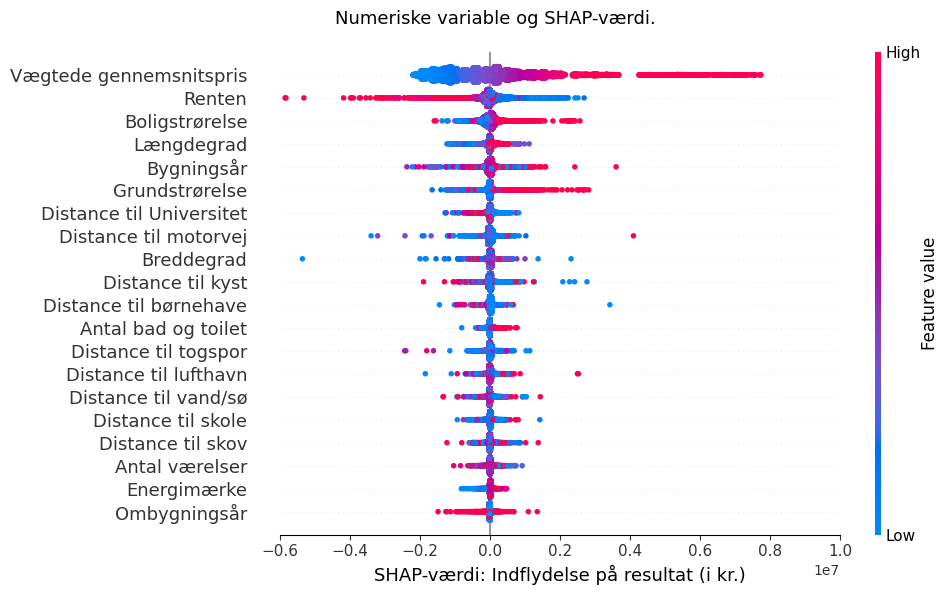

In [484]:
plt.suptitle("Numeriske variable og SHAP-værdi.", fontsize=13)
plt.xlim(-6000000,10000000)
shap.summary_plot(shap_values, X_test ,plot_size=(10,6), show=False, feature_names=feature_names)
plt.xlabel('SHAP-værdi: Indflydelse på resultat (i kr.)')
plt.show()

In [227]:
# Feature importance numerisk!
np.abs(shap_values_original).sum(axis=0).sort_values(ascending=False)

weighted_price         22357684224
interest_30_maturity    3682961152
Distances               2696882944
area                    2470677248
longitude               1349109632
build_year              1247756032
grund_str                953853952
latitude                 611424896
badtoi                   546949760
rooms                    333106432
Energylabel              329895968
tagkode                  299007840
ombygaar                 286165536
varmesinstallation       162411760
Region                   117297184
vægmateriale              79968080
Byzone                    30971624
dtype: float32

In [229]:
X_test.columns

Index(['rooms', 'build_year', 'area', 'Byzone', 'dist_coast', 'dist_highway',
       'dist_railroads', 'dist_airports', 'longitude', 'latitude', 'grund_str',
       'interest_30_maturity', 'dist_uni', 'ombygaar', 'Energylabel',
       'dist_school', 'dist_kindergarden', 'dist_waterlines', 'dist_forests',
       'weighted_price', 'badtoi', 'Region_Region Midtjylland',
       'Region_Region Nordjylland', 'Region_Region Sjælland',
       'Region_Region Syddanmark', 'varmesinstallation_Centralvarme',
       'varmesinstallation_Elvarme', 'varmesinstallation_Fjernvarme/blokvarme',
       'varmesinstallation_Gasradiator',
       'varmesinstallation_Ingen varmeinstallation', 'varmesinstallation_Ovn',
       'varmesinstallation_Varmepumpe', 'tagkode_Betontagsten',
       'tagkode_Fibercement', 'tagkode_Fibercement asbest', 'tagkode_Glas',
       'tagkode_Levende', 'tagkode_Metal', 'tagkode_Plastmaterialer',
       'tagkode_Stråtag', 'tagkode_Tagpap', 'tagkode_Tagpap hældning',
       'tagkode_T

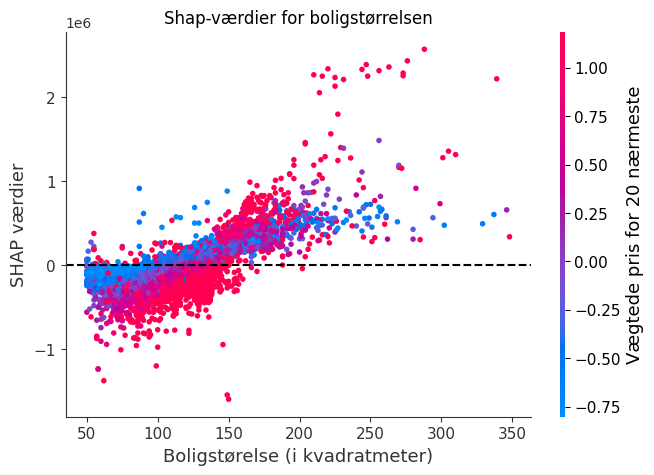

In [448]:
# SHAP-plot af sammenhæng mellem boligstørelse og vægtede pris af 20 nærmeste!
shap.dependence_plot('area',shap_values, X_test.rename(columns={'weighted_price': 'Vægtede pris for 20 nærmeste'}), interaction_index='Vægtede pris for 20 nærmeste', show=False)
plt.title("Shap-værdier for boligstørrelsen")
plt.ylabel("SHAP værdier")
plt.xlabel("Boligstørelse (i kvadratmeter)")
plt.axhline(y=0, color='black', linestyle='--', label='y=0')

plt.show()

In [485]:
X_test.columns

Index(['rooms', 'build_year', 'area', 'Byzone', 'dist_coast', 'dist_highway',
       'dist_railroads', 'dist_airports', 'longitude', 'latitude', 'grund_str',
       'interest_30_maturity', 'dist_uni', 'ombygaar', 'Energylabel',
       'dist_school', 'dist_kindergarden', 'dist_waterlines', 'dist_forests',
       'weighted_price', 'badtoi', 'Region_Region Midtjylland',
       'Region_Region Nordjylland', 'Region_Region Sjælland',
       'Region_Region Syddanmark', 'varmesinstallation_Centralvarme',
       'varmesinstallation_Elvarme', 'varmesinstallation_Fjernvarme/blokvarme',
       'varmesinstallation_Gasradiator',
       'varmesinstallation_Ingen varmeinstallation', 'varmesinstallation_Ovn',
       'varmesinstallation_Varmepumpe', 'tagkode_Betontagsten',
       'tagkode_Fibercement', 'tagkode_Fibercement asbest', 'tagkode_Glas',
       'tagkode_Levende', 'tagkode_Metal', 'tagkode_Plastmaterialer',
       'tagkode_Stråtag', 'tagkode_Tagpap', 'tagkode_Tagpap hældning',
       'tagkode_T

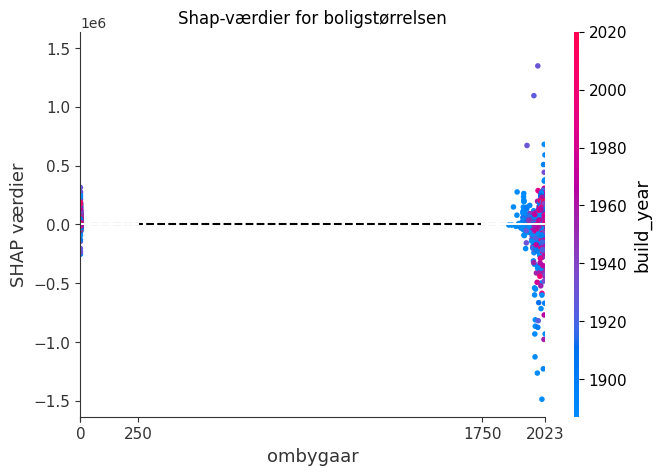

In [503]:
# SHAP-plot af sammenhæng mellem boligstørelse og vægtede pris af 20 nærmeste!
shap.dependence_plot('ombygaar',shap_values, X_test, interaction_index='build_year', show=False)
plt.title("Shap-værdier for boligstørrelsen")
plt.ylabel("SHAP værdier")
#plt.xlabel("Boligstørelse (i kvadratmeter)")
plt.axhline(y=0, color='black', linestyle='--', label='y=0')

plt.show()

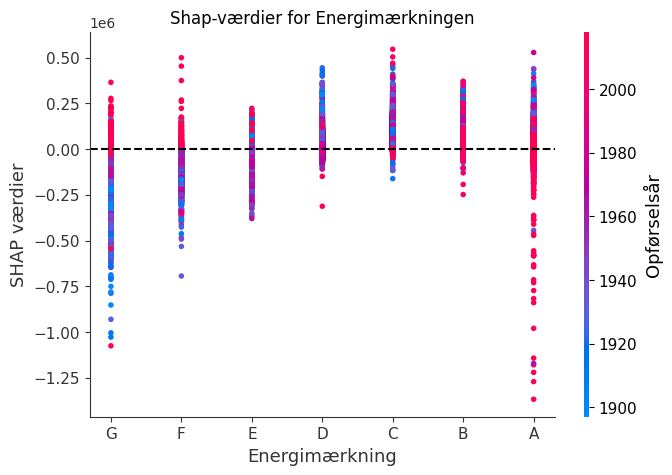

In [320]:
# SHAP-plot af sammenhængen mellem energimærkning og bygningsåret
shap.dependence_plot('Energylabel',shap_values, X_test.rename(columns={'build_year': 'Opførselsår'}), interaction_index='Opførselsår', show=False)
plt.title("Shap-værdier for Energimærkningen")
plt.ylabel("SHAP værdier")
plt.xlabel("Energimærkning")
plt.xticks([1,2,3,4,5,6,7],['G','F','E','D','C','B','A'])
plt.axhline(y=0, color='black', linestyle='--', label='y=0')

plt.show()

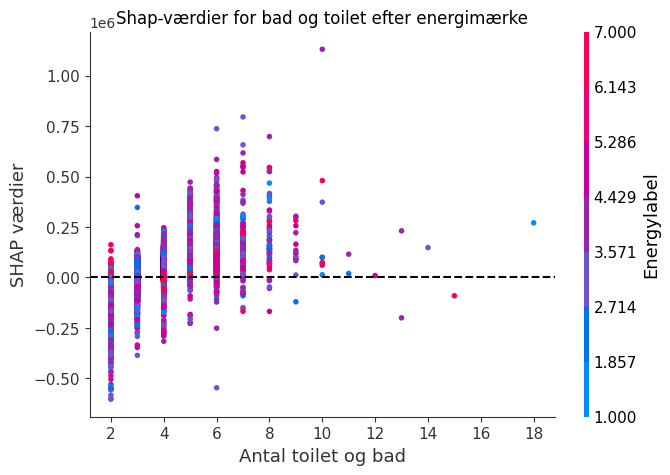

In [321]:
# SHAP-plot af sammenhængen mellem antal badeværelser og toiletter samt energimærkning
shap.dependence_plot('badtoi', shap_values, X_test, interaction_index='Energylabel', show=False)
plt.title("Shap-værdier for bad og toilet efter energimærke")
plt.ylabel("SHAP værdier")
plt.xlabel("Antal toilet og bad")
plt.axhline(y=0, color='black', linestyle='--', label='y=0')

plt.show()

In [130]:
## Shaper nyt dataframe af SHAP-værdier efter originale kolonner. Er kun konstrueret igen som forsikring om ingen fejl.
original_feature_names = df.drop('price',axis=1).columns
shap_values_df_new = pd.DataFrame(shap_values, columns=X_test.columns)
shap_values_original_new = pd.DataFrame(index=shap_values_df_new.index, columns=original_feature_names)

numerical_features = ['rooms', 'build_year', 'area', 'Byzone', 'dist_coast',
       'dist_highway', 'dist_railroads', 'dist_airports', 'longitude',
       'latitude', 'grund_str','interest_30_maturity', 'dist_uni', 'ombygaar', 'Energylabel',
       'dist_school', 'dist_kindergarden','dist_waterlines', 'dist_forests', 'weighted_price', 'badtoi']
for feature in original_feature_names:
        if feature in numerical_features:
                shap_values_original_new[feature] = shap_values_df_new[feature]
        else:
                related_columns = [col for col in shap_values_df_new.columns if col.startswith(f"{feature.split('_')[0]}")]
                shap_values_original_new[feature] = shap_values_df_new[related_columns].sum(axis=1)

In [131]:
X_test_shh = X_test.reset_index(inplace=False, drop=True)

In [132]:
data_4_later = data_4_later[data_4_later['anvendelse'] == Model_variation].drop('Sogn',axis=1) # Data til senere brug ved SHAP!
data_4_shap = data_4_later.loc[X_test.index].reset_index(drop=True, inplace=False)

In [133]:
X_test = X_test.reset_index(drop=True)

In [134]:
#Tilfældigt indtastede værdi ved "random" tast på tastatur
nummer = 9987

# Selecterer kolonne
row_of_interest = X_test.iloc[nummer, :]

# Fjerner rækken i fokus fra dataset.
X_no_id = X_test.drop(X_test.index[nummer])

# Bruger PCA med 10 komponenter -- Reducerer træningsdata til 10 dimensioner for hurtig cosine-similarity
pca = PCA(n_components=10)
#Fit transform
X_train_pca = pca.fit_transform(X_no_id)
#Transformere rækken af interesse
row_of_interest_pca = pca.transform(row_of_interest.values.reshape(1, -1))


# beregner cosine similariti
cosine_similarities = cosine_similarity(row_of_interest_pca, X_train_pca)

# Find mest lignende observation og gem index
most_similar_index = cosine_similarities.argmax()

# Find originale observation i data.
most_similar_observation = X_test.iloc[most_similar_index, :]

X does not have valid feature names, but PCA was fitted with feature names


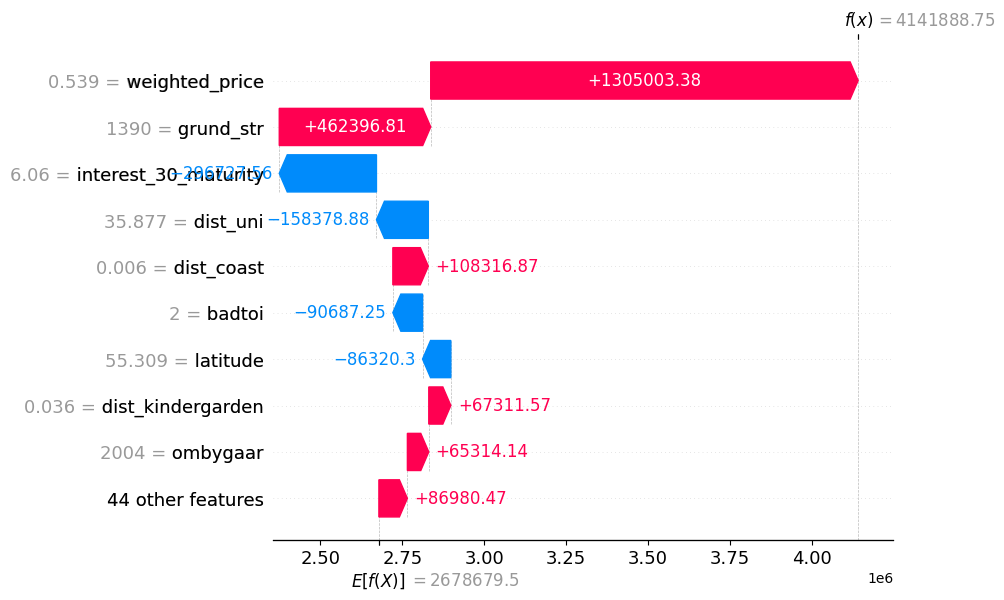

In [135]:
# SHAP-waterfall plot til at se sammenlignelighed - "Tilfældigt" valgt nummer
plt.figure(figsize=(5, 5))  
shap.plots.waterfall(shap.Explanation(values=shap_values[nummer],
                                     base_values=explainer.expected_value,
                                     data=X_test_shh.iloc[nummer]))

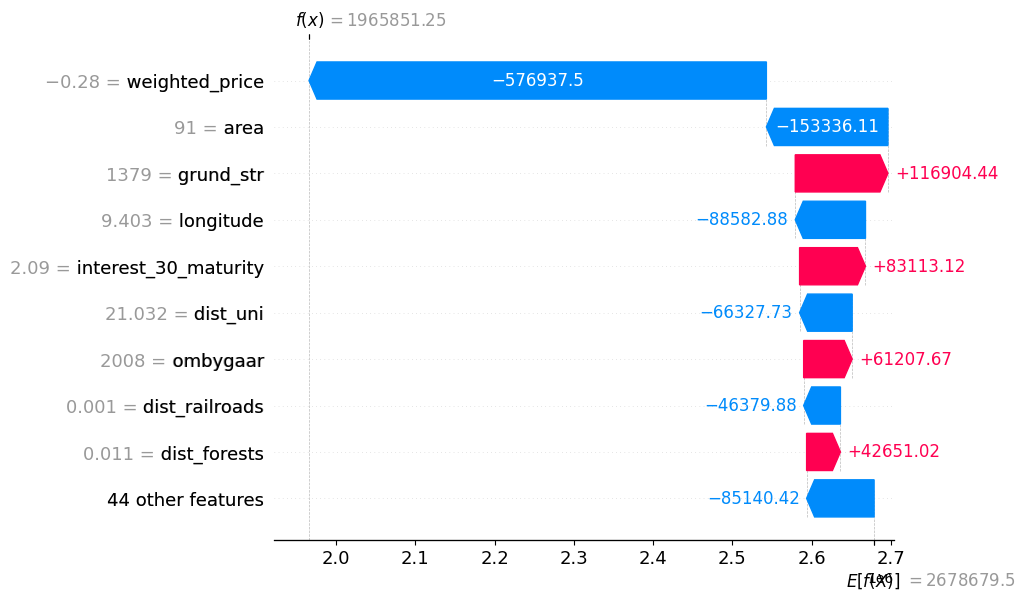

In [136]:
# SHAP-plot af mes sammenlignelige til valgt nummer
plt.figure(figsize=(5, 5)) 
shap.plots.waterfall(shap.Explanation(values=shap_values[most_similar_index],
                                     base_values=explainer.expected_value,
                                     data=X_test_shh.iloc[most_similar_index]))

In [137]:
# Laver forklaringer for begge observationer
bolig_index_1 = nummer
bolig_index_2 = most_similar_index

forklaring1 = shap.Explanation(values=shap_values_original_new.to_numpy()[bolig_index_1],
                                     base_values=explainer.expected_value,
                                     data=data_4_shap.drop('price', axis=1).iloc[bolig_index_1])
forklaring2 = shap.Explanation(values=shap_values_original_new.to_numpy()[bolig_index_2],
                                     base_values=explainer.expected_value,
                                     data=data_4_shap.drop('price', axis=1).iloc[bolig_index_2])

In [138]:
## De faktiske priser og den predictede pris
print(
    f"""For bolig 1 er faktisk pris: {int(round((data_4_shap.iloc[bolig_index_1]['price'])))} \n
    Den predictede værdi er:  {int(round((loaded_model.predict(X_test.iloc[[bolig_index_1]])[0])))} \n
    For bolig 2 er faktisk pris: {int(round((data_4_shap.iloc[bolig_index_2]['price'])))} \n
    Den predictede værdi er:  {int(round((loaded_model.predict(X_test.iloc[[bolig_index_2]])[0])))}
    """)

For bolig 1 er faktisk pris: 4191690 

    Den predictede værdi er:  4141893 

    For bolig 2 er faktisk pris: 1527030 

    Den predictede værdi er:  1965852
    


In [139]:
## Laver tabel over de 2 observationer og deres SHAP-værdier:
pd.set_option('display.float_format', lambda x: '%.0f' % x)
Table = pd.DataFrame({'Forklaring1':forklaring1.data,'Shap1':forklaring1.values,
'Shap2':forklaring2.values ,'Forklaring2':forklaring2.data}).round()
Table
#pd.reset_option('display.float_format')

,Forklaring1,Shap1,Shap2,Forklaring2
rooms,5,-35645,-10669,4
build_year,1969,-34182,6099,1990
area,100,-51318,-153336,91
Region,Region Syddanmark,15046,7881,Region Midtjylland
Byzone,1,3965,-259,1
dist_coast,0,108317,-25621,12
dist_highway,0,37012,-33353,28
dist_railroads,0,30088,-46380,0
dist_airports,57,2062,12573,81
longitude,11,30570,-88583,9


In [140]:
# Værdi for øvrige
øvrige = Table[Table.index.str.startswith("vægmateriale") | Table.index.str.startswith("Byzone") |
Table.index.str.startswith("anvendelse") | Table.index.str.startswith("Region")]

# Sum af øvrige:
øvrige[['Shap1','Shap2']].sum(axis=0)

Shap1   21220
Shap2    6461
dtype: float64